In [1]:
import sys
sys.path.insert(0,'../src/')
from curve import *
from utils import *
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [2]:
with open('./pipes_and_shifts.pickle','rb') as f:
    pipes, shifts = pickle.load(f)

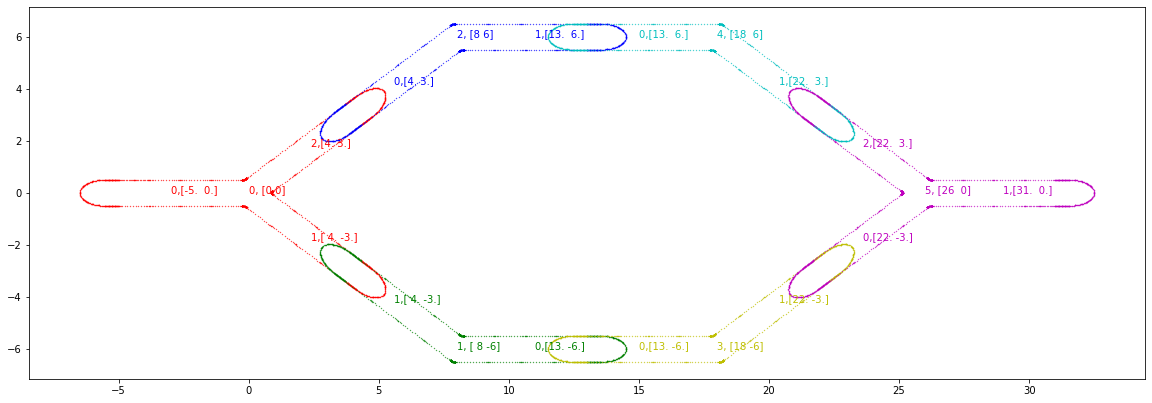

In [3]:
color = ['r','g','b','y','c','m','k']

fig,ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')

for a,i,j,c in zip(range(10),pipes,shifts,color):
    
    ax.scatter(i.t.real + j[0], i.t.imag + j[1],c=c,s=0.1)
    for k,let in enumerate(i.lets):
        ax.text(*(0.6*let.matching_pt + j),f'{k},{let.matching_pt + j}',color=c)
    ax.text(*j,f'{a}, {j}',color=c)

In [4]:
p = pipes[0]

In [6]:
np.sum([len(c.t) for c in p.boundaries[0].curves if not isinstance(c,Cap)])

976